# Классификация: превышает ли значение SI медианное значение выборки

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd

# Загружаем датасет
# df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Классическое МО/Курсовая/df_EDA.xlsx')
df = pd.read_excel('df_EDA.xlsx')

# Вычисляем медиану
median_SI = df['SI'].median()

# Определяем целевую переменную SI
y = (df['SI'] > median_SI).astype(int)

# Исключаем лишние переменные
X = df.drop(columns=['IC50, mM', 'CC50, mM', 'SI', 'IC50, mM_lg', 'CC50, mM_lg', 'SI_lg'])

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train dataset size: {X_train.shape}, {y_train.shape}")
print(f"Test dataset size: {X_test.shape}, {y_test.shape}")

Train dataset size: (800, 192), (800,)
Test dataset size: (201, 192), (201,)


In [4]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00


In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.8 MB/s eta 0:00:00


In [6]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем словарь моделей и их гиперпараметров
classificators = {
    'Случайный лес': {
        'модель': RandomForestClassifier(),
        'параметры': {
            'n_estimators': [50, 100, 150],
            'max_depth': [6, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'модель': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'параметры': {
            'max_depth': [3, 6, 10],
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'CatBoost': {
        'модель': CatBoostClassifier(silent=True),
        'параметры': {
            'depth': [3, 6, 10],
            'iterations': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'K ближайших соседей': {
        'модель': KNeighborsClassifier(),
        'параметры': {
            'n_neighbors': list(range(1, 21)),
            'weights': ['uniform', 'distance']
        }
    },
    'Градиентный бустинг': {
        'модель': GradientBoostingClassifier(),
        'параметры': {
            'n_estimators': [100, 150],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1]
        }
    }
}

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [0.01, 0.1] was inferred to Real(low=0.01, high=0.1, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.01, 0.1), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/l

Общее время: 386.45 секунд

Лучшая модель: Случайный лес
Лучшие гиперпараметры: OrderedDict([('max_depth', 10), ('min_samples_leaf', 4), ('min_samples_split', 2), ('n_estimators', 100)])
Лучшее ROC_AUC: 0.727


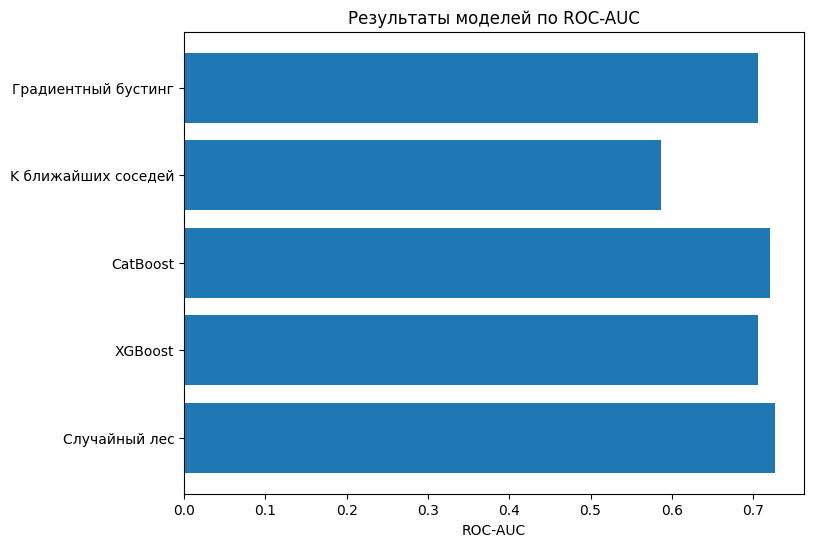

                Модель   ROC_AUC  Accuracy    Recall  Precision  F1-score  \
0        Случайный лес  0.726681  0.681592  0.681592   0.680833  0.680123   
1              XGBoost  0.706517  0.651741  0.651741   0.652320  0.651966   
2             CatBoost  0.720957  0.656716  0.656716   0.656475  0.656580   
3  K ближайших соседей  0.586371  0.611940  0.611940   0.617004  0.612286   
4  Градиентный бустинг  0.706500  0.676617  0.676617   0.676876  0.676730   

                                      Гиперпараметры  
0  {'max_depth': 10, 'min_samples_leaf': 4, 'min_...  
1  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...  
2  {'depth': 10, 'iterations': 150, 'learning_rat...  
3          {'n_neighbors': 9, 'weights': 'distance'}  
4  {'learning_rate': 0.0831156389521627, 'max_dep...  


In [7]:
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV

# Начинаем таймер
start_time = time.time()

best_model_name = None
best_score = -float('inf')
best_params = {}
results = []

for name, config in classificators.items():
    model = config['модель']
    params = config['параметры']

    # Настраиваем байесовский поиск гиперпараметров
    bayes_cv = BayesSearchCV(
        estimator=model,
        search_spaces=params,
        n_iter=5,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    # Обучение и поиск лучших гиперпараметров
    bayes_cv.fit(X_train, y_train)

    # Предсказания на тестовом наборе
    y_pred = bayes_cv.predict(X_test)

    # Вычисляем метрики
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Запоминаем лучший результат
    if bayes_cv.best_score_ > best_score:
        best_score = bayes_cv.best_score_
        best_model_name = name
        best_params = bayes_cv.best_params_

    # Собираем все показатели для итоговой таблицы
    results.append({
        'Модель': name,
        'ROC_AUC': bayes_cv.best_score_,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1-score': f1,
        'Гиперпараметры': bayes_cv.best_params_
    })

# Время работы
print(f"Общее время: {time.time() - start_time:.2f} секунд")
# Итог
print(f"\nЛучшая модель: {best_model_name}")
print(f"Лучшие гиперпараметры: {best_params}")
print(f"Лучшее ROC_AUC: {best_score:.3f}")

# Визуализация результатов
import matplotlib.pyplot as plt
results_df = pd.DataFrame(results)

# График ROC-AUC
plt.figure(figsize=(8,6))
plt.barh(results_df['Модель'], results_df['ROC_AUC'])
plt.xlabel('ROC-AUC')
plt.title('Результаты моделей по ROC-AUC')
plt.show()

# Итоговая таблица
print(results_df)

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Создаем модель с нужными параметрами
best_catboost_model = CatBoostClassifier(depth=10, iterations=150, learning_rate=0.01, silent=True)

# Обучаем на тренировочных данных
best_catboost_model.fit(X_train, y_train)

# Делаетм предсказания по всему датасету
y_pred = best_catboost_model.predict(X)

# Оценка метрик
accuracy = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred, average='weighted')
precision = precision_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

# Выводим результаты
print(f'Точность (Accuracy): {accuracy:.4f}')
print(f'Полнота (Recall): {recall:.4f}')
print(f'Точность (Precision): {precision:.4f}')
print(f'F1-score: {f1:.4f}')

Точность (Accuracy): 0.8352
Полнота (Recall): 0.8352
Точность (Precision): 0.8353
F1-score: 0.8352
